In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

2023-06-06 07:19:43.290190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 07:19:46.142718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-06 07:19:46.142830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
import bayesflow
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d
from custom_plots import plot_sbc_ecdf

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Parameters for publication-ready plot
plt.rcParams.update({
    "axes.labelsize" : 24,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize": 24,
    "text.usetex": False,
    "font.family": "serif",
    #"font.serif": ["times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

# Benchmark: Gaussian Mixture

In [4]:
benchmark_name = 'gaussian_mixture'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the gaussian_mixture model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
def custom_configure(input_dict, preconfigured=False):
    """Scales down default prior range from [-10, 10] to [-1, 1]."""

    if not preconfigured:
        input_dict = benchmark.configurator(input_dict)
    input_dict['posterior_inputs']['parameters'] /= 10
    input_dict['likelihood_inputs']['conditions'] /= 10
    return input_dict

In [6]:
settings = {
    'dense_args': dict(units=64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    'dropout_prob': 0.05,
    'num_dense': 1
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=6,
    permutation='learnable',
    coupling_design='spline',
    coupling_settings=settings,
)

inference_net_l = InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=6,
    coupling_design='spline',
    coupling_settings=settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior, 
    amortized_likelihood
)

2023-06-06 07:19:51.605229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 07:19:51.619791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 07:19:51.621584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 07:19:51.624457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=custom_configure,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
2023-06-06 07:19:58.583796: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x564a616c2f90
INFO:root:Done.


# Training
Uncomment for training. Wall time on GPU approx. 41min 52s

In [11]:
# EPOCHS = 150
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 64

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [10]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Curves

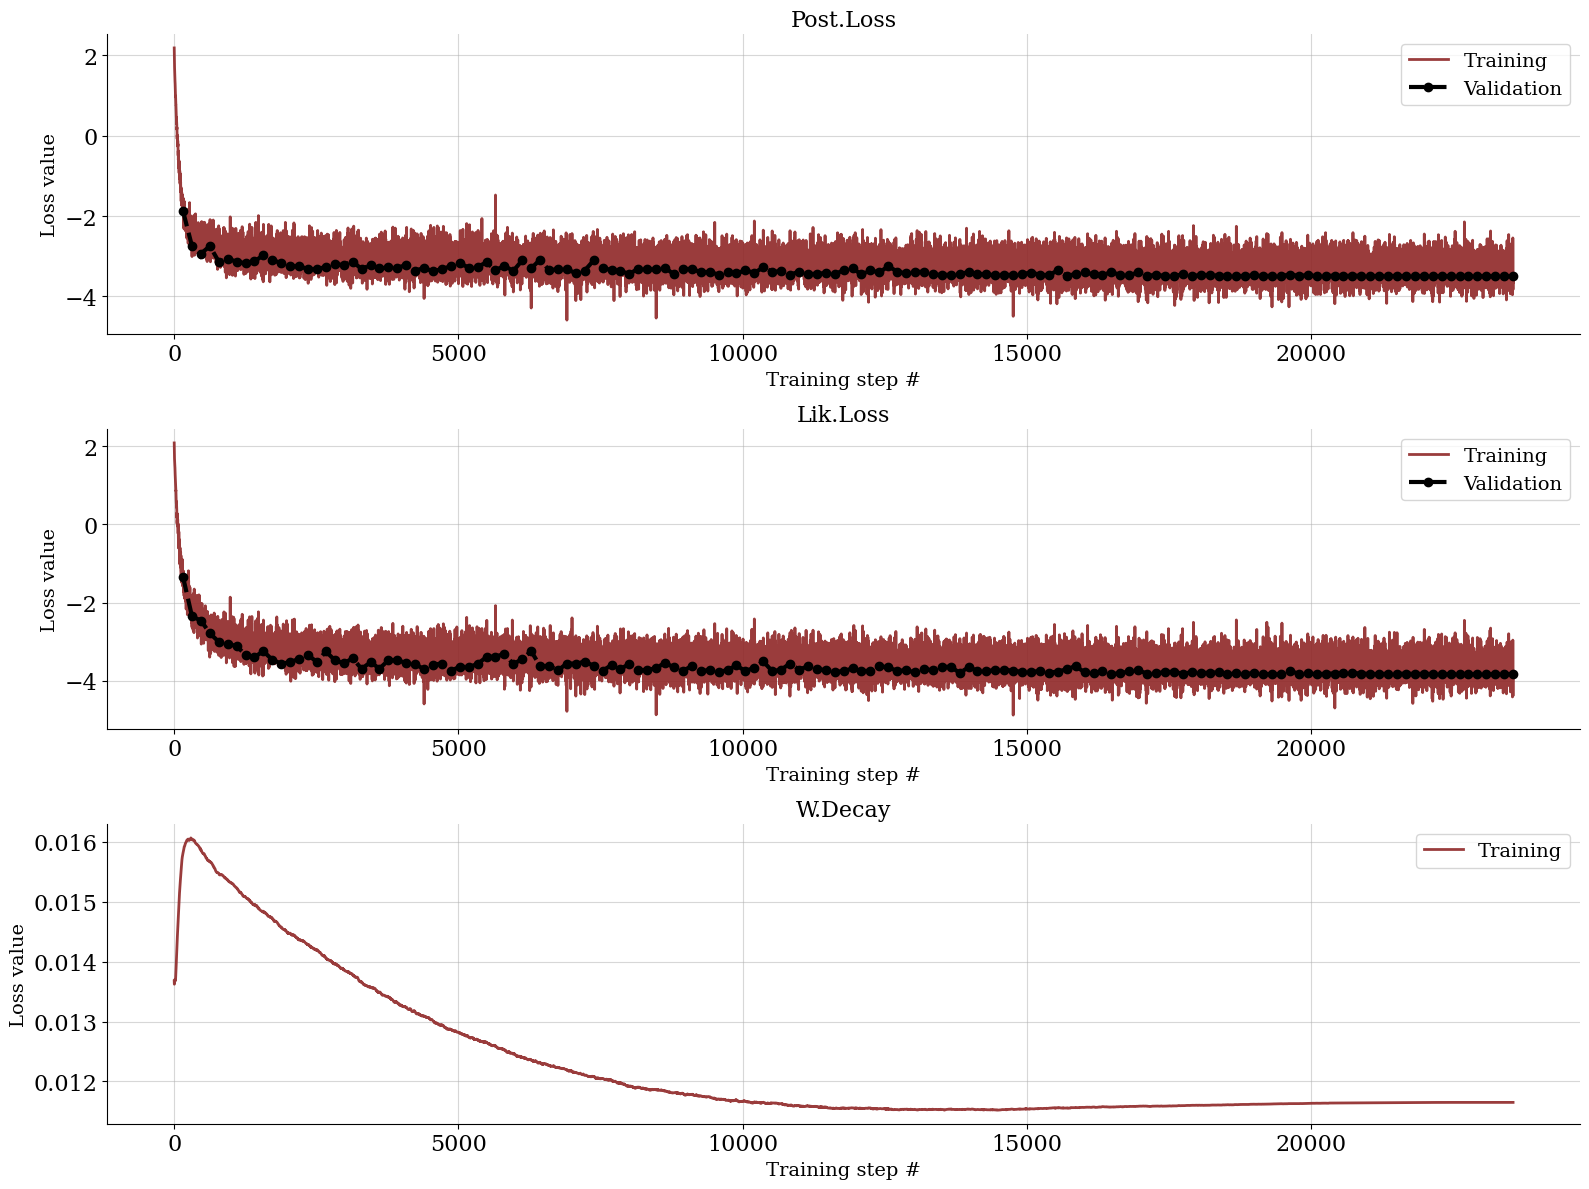

In [12]:
# # Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [13]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)
test_dict = custom_configure(test_dict, preconfigured=True)

In [14]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

## Individual Calibration Plots

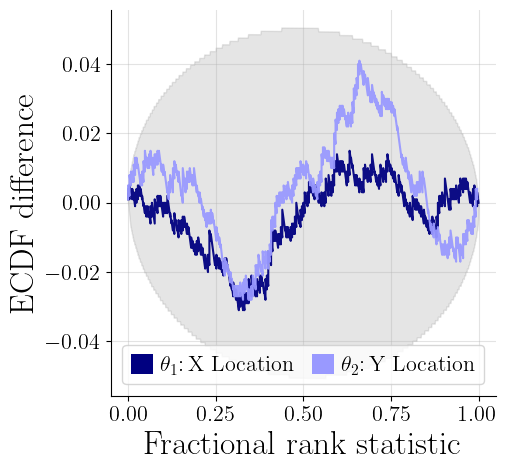

In [16]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    label_fontsize=24,
    legend_fontsize=16,
    difference=True, 
    param_names=[r'$\theta_1$:\,X Location', r'$\theta_2$:\,Y Location'], 
    rank_ecdf_colors=['#000080', '#9999FF']
)

f.savefig(f'figures/{benchmark_name}_diff_ind_post.pdf', dpi=300, bbox_inches='tight')

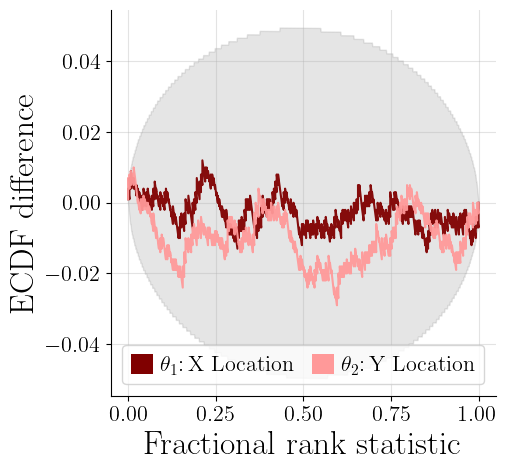

In [17]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(
    post_samples_s,
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    label_fontsize=24, 
    legend_fontsize=16,
    difference=True, 
    param_names=[r'$\theta_1$:\,X Location', r'$\theta_2$:\,Y Location'], 
    rank_ecdf_colors=['#800000', '#FF9999']
)

f.savefig(f'figures/{benchmark_name}_diff_ind_joint.pdf', dpi=300, bbox_inches='tight')

# Appendix Plots

In [18]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

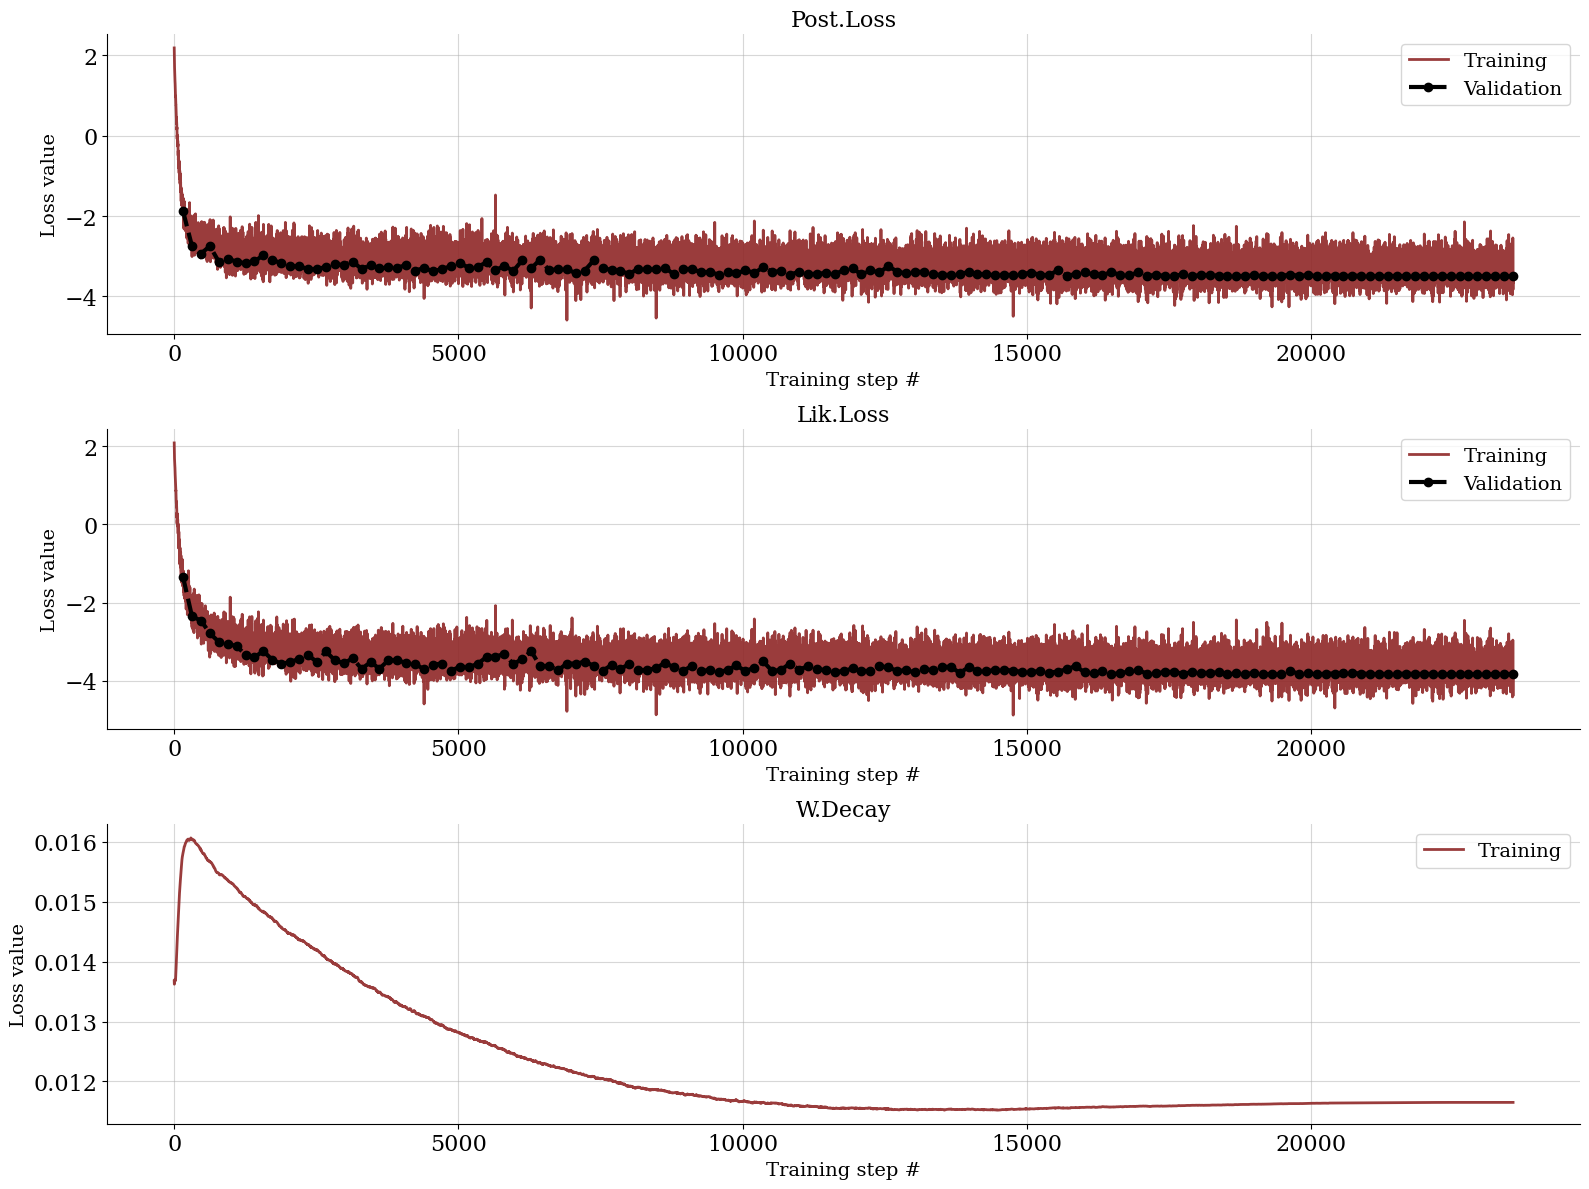

In [19]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

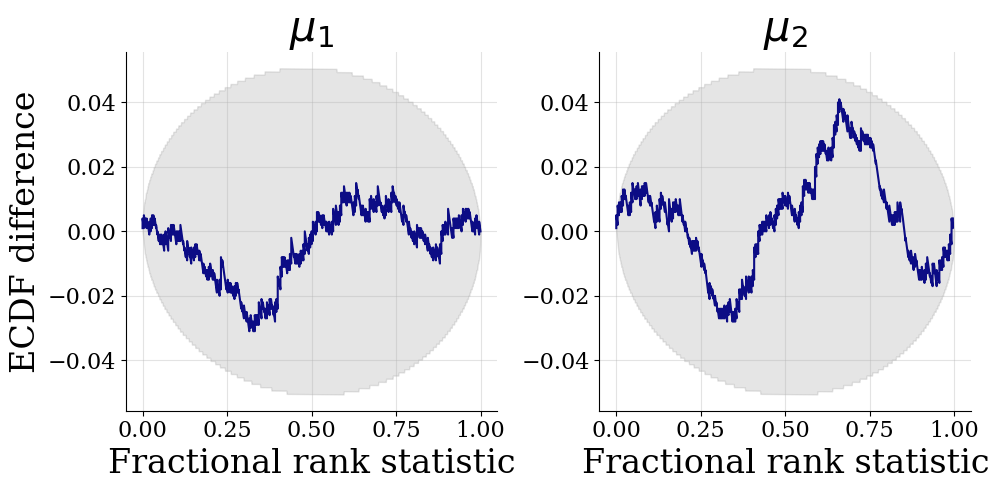

In [20]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

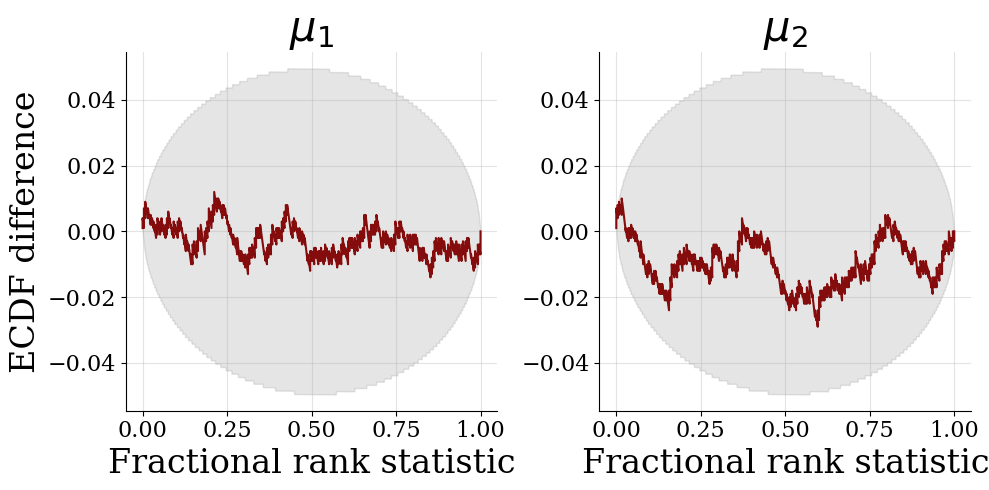

In [21]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")